<a href="https://colab.research.google.com/github/davidwhogg/EmuCosmoSim/blob/main/ipynb/group_averaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding equivariant convolution operators by group averaging

## Authors:
- **David W. Hogg** (NYU) (Flatiron)
- **Soledad Villar** (JHU)

## License
Copyright 2022 the authors. All rights reserved *for now*.

## To-do
- Implement a `geometric_image` class.
- Within the `geometric_image` class define a `convolve` function that takes a `geometric_filter`.
- Implement div and curl of filters so we can orient them.

## Bugs:
- Haven't figured out yet how to visualize the 2-tensor filters; maybe plot eigenvalues and eigenvectors?
- The group operators should be found by recursion; this ought to be more efficient.
- Fix 3-d plotting so it does a real projection (not just a set of incomprehensible hacks).


In [1]:
import numpy as np
import pylab as plt
import itertools as it
import scipy.signal as sig

In [2]:
# Set integers:
D = 2 # D-dimensional image (must be 2 or 3 for plotting to work)
M = 3 # must be an odd integer

# Get the group ready and test it

In [3]:
# Make all possible group generators

# Make the flip operator
foo = np.ones(D).astype(int)
foo[0] = -1
gg = np.diag(foo).astype(int)
generators = [gg, ]

# Make the 90-degree rotation operators
for i in range(D):
    for j in range(i + 1, D):
        gg = np.eye(D).astype(int)
        gg[i, i] = 0
        gg[j, j] = 0
        gg[i, j] = -1
        gg[j, i] = 1
        generators.append(gg)
generators = np.array(generators)

# Look at them
for gg in generators:
    print(gg)

[[-1  0]
 [ 0  1]]
[[ 0 -1]
 [ 1  0]]


In [4]:
# Make all possible group operators.
# This code is very wasteful; there is a better way with recursion.

def make_all_operators(generators):
    operators = np.array([np.eye(D).astype(int), ])
    foo = 0
    while len(operators) != foo:
        foo = len(operators)
        operators = make_new_operators(operators, generators)
    return(operators)

def make_new_operators(operators, generators):
    for op in operators:
        for gg in generators:
            op2 = (gg @ op).astype(int)
            operators = np.unique(np.append(operators, op2[None, :, :], axis=0), axis=0)
    return operators

group_operators = make_all_operators(generators)
print("I found", len(group_operators), "group operators; here are their determinants:")
for gg in group_operators:
    print(gg, "determinant:", np.linalg.slogdet(gg)[0].astype(int))

I found 8 group operators; here are their determinants:
[[-1  0]
 [ 0 -1]] determinant: 1
[[-1  0]
 [ 0  1]] determinant: -1
[[ 0 -1]
 [-1  0]] determinant: -1
[[ 0 -1]
 [ 1  0]] determinant: 1
[[ 0  1]
 [-1  0]] determinant: 1
[[0 1]
 [1 0]] determinant: -1
[[ 1  0]
 [ 0 -1]] determinant: -1
[[1 0]
 [0 1]] determinant: 1


In [5]:
# Check that the list of group operators is closed
for gg in group_operators:
    for gg2 in group_operators:
        assert ((gg @ gg2).astype(int) in group_operators)
    print(gg, True)

[[-1  0]
 [ 0 -1]] True
[[-1  0]
 [ 0  1]] True
[[ 0 -1]
 [-1  0]] True
[[ 0 -1]
 [ 1  0]] True
[[ 0  1]
 [-1  0]] True
[[0 1]
 [1 0]] True
[[ 1  0]
 [ 0 -1]] True
[[1 0]
 [0 1]] True


In [6]:
# Check that gg.T is gg.inv for all gg in group?
for gg in group_operators:
    print(gg, np.allclose(gg @ gg.T, np.eye(D)))

[[-1  0]
 [ 0 -1]] True
[[-1  0]
 [ 0  1]] True
[[ 0 -1]
 [-1  0]] True
[[ 0 -1]
 [ 1  0]] True
[[ 0  1]
 [-1  0]] True
[[0 1]
 [1 0]] True
[[ 1  0]
 [ 0 -1]] True
[[1 0]
 [0 1]] True


# Define the geometric objects and geometric filters
- And visualize them.

In [7]:
class ktensor:

    def __init__(self, data, parity, D=D):
        self.D = D
        assert self.D > 1, \
        "ktensor: geometry makes no sense if D<2."
        self.parity = parity
        assert np.abs(self.parity) == 1, \
        "ktensor: parity must be 1 or -1."
        if len(np.atleast_1d(data)) == 1:
            self.data = data
            self.k = 0
        else:
            self.data = np.array(data)
            self.k = len(data.shape)
            assert np.all(np.array(data.shape) == D), \
            "ktensor: shape must be (D, D, D, ...)."

    def __getitem__(self, key):
        return self.data[key]

    def __add__(self, other):
        assert self.k == other.k, \
        "ktensor: can't add objects of different k"
        assert self.parity == other.parity, \
        "ktensor: can't add objects of different parity"
        return ktensor(self.data + other.data, self.parity)

    def __mul__(self, other):
        if self.k == 0 or other.k == 0:
            return ktensor(self.data * other.data,
                           self.parity * other.parity)
        return ktensor(np.outer(self.data, other.data),
                       self.parity * other.parity)

    def __str__(self):
        return "<k-tensor object in D={} with k={} and parity={}>".format(
            self.D, self.k, self.parity)

    def norm(self):
        if self.k == 0:
            return np.abs(self.data)
        return np.linalg.norm(self.data, ord=2)

    def times_group_element(self, gg):
        # BUG: THIS IS UNTESTED.
        # BUG: This is incomprehensible.
        assert self.k < 14
        assert gg.shape == (D, D)
        sign, logdet = np.linalg.slogdet(gg)
        assert logdet == 0.
        if self.k == 0:
            newdata = 1. * self.data
        else:
            firstletters  = "abcdefghijklm"
            secondletters = "nopqrstuvwxyz"
            einstr = "".join([firstletters[i] for i in range(self.k)]) +"," + \
            ",".join([secondletters[i] + firstletters[i] for i in range(self.k)])
            foo = (self.data, ) + self.k * (gg, )
            newdata = np.einsum(einstr, *foo)
        if self.parity < 0:
            newdata *= sign
        return ktensor(newdata, self.parity)

In [8]:
class geometric_filter:

    def hash(self, pixel):
        return tuple(pixel.astype(int))

    def make_pixels_and_keys(self):
        foo = range(-self.m, self.m + 1)
        self._pixels = np.array([pp for pp in it.product(foo, repeat=D)]).astype(int)
        self._keys = [self.hash(pp) for pp in self._pixels]
        return

    def __init__(self, data, parity, D=D):
        self.D = D
        self.M = np.round(len(data) ** (1. / D)).astype(int)
        assert len(data) == self.M ** self.D, \
        "geometric_filter: data doesn't seem to be the right length?"
        self.m = (self.M - 1) // 2
        assert self.M == 2 * self.m + 1, \
        "geometric_filter: M needs to be odd."
        self.make_pixels_and_keys()
        self.parity = parity
        self.data = {kk: ktensor(ff, self.parity, self.D)
                     for kk, ff in zip(self.keys(), data)}
        self.k = self[self.keys()[0]].k
        return

    def copy(self):
        return geometric_filter(self.unpack(), self.parity, self.D)

    def __getitem__(self, key):
        return self.data[key]

    def keys(self):
        return self._keys

    def pixels(self):
        return self._pixels

    def __add__(self, other):
        assert self.D == other.D
        assert self.M == other.M
        newfilter = self.copy()
        for kk in self.keys():
            newfilter.data[kk] = self[kk] + other[kk]
        return newfilter

    def __str__(self):
        return "<geometric filter object in D={} with M={}, k={}, and parity={}>".format(
            self.D, self.M, self.k, self.parity)

    def times_group_element(self, gg):
        newfilter = self.copy()
        for pp, kk in zip(self.pixels(), self.keys()):
            newfilter.data[kk] = self[self.hash(gg.T @ pp)].times_group_element(gg)
        return newfilter

    def unpack(self):
        return np.array([self[kk].data for kk in self.keys()])

    def bigness(self):
        numerator, denominator = 0., 0.
        for pp, kk in zip(self.pixels(), self.keys()):
            numerator += np.linalg.norm(pp * self[kk].norm(), ord=2)
            denominator += self[kk].norm()
        return numerator / denominator


In [31]:
# Visualize (badly) a scalar filter.

FIGSIZE = (4, 3)
XOFF, YOFF = 0.15, -0.1
TINY = 1.e-5

def setup_plot():
    fig = plt.figure(figsize=FIGSIZE)

def finish_plot(title, pixels):
    plt.title(title)
    if D == 2:
        plt.xlim(np.min(pixels)-0.5, np.max(pixels)+0.5)
        plt.ylim(np.min(pixels)-0.5, np.max(pixels)+0.5)
    if D == 3:
        plt.xlim(np.min(pixels)-0.75, np.max(pixels)+0.75)
        plt.ylim(np.min(pixels)-0.75, np.max(pixels)+0.75)
    plt.gca().set_aspect("equal")
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

def plot_boxes(xs, ys):
    for x, y in zip(xs, ys):
        plt.plot([x-0.5, x-0.5, x+0.5, x+0.5, x-0.5],
                 [y-0.5, y+0.5, y+0.5, y-0.5, y-0.5], "k-", lw=0.5)

def fill_boxes(xs, ys, ws):
    for x, y, w in zip(xs, ys, ws):
        if np.abs(w) > TINY:
            plt.fill_between([x - 0.5, x + 0.5], [y - 0.5, y - 0.5], [y + 0.5, y + 0.5],
                             color="k", alpha=0.1 * np.abs(w))

def plot_scalars(xs, ys, ws, boxes=True, fill=True, symbols=True):
    if boxes:
        plot_boxes(xs, ys)
    if fill:
        fill_boxes(xs, ys, ws)
    if symbols:
        plt.scatter(xs[ws > TINY], ys[ws > TINY],
                    marker="+", c="k", s=(1000/M)*ws[ws > TINY])
        plt.scatter(xs[ws < TINY], ys[ws < TINY],
                    marker="_", c="k", s=(-1000/M)*ws[ws < TINY])

def plot_scalar_filter(filter, title):
    assert filter.k == 0
    if filter.D not in [2, 3]:
        print("plot_scalar_filter(): Only works for D in [2, 3].")
        return
    setup_plot()
    MtotheD = filter.M ** filter.D
    xs, ys, zs = np.zeros(MtotheD), np.zeros(MtotheD), np.zeros(MtotheD)
    ws = np.zeros(MtotheD)
    for i, (kk, pp) in enumerate(zip(filter.keys(), filter.pixels())):
        ws[i] = filter[kk].data
        if filter.D == 2:
            xs[i], ys[i] = pp
        elif filter.D == 3:
            xs[i], ys[i] = pp[0] + XOFF * pp[2], pp[1] + XOFF * pp[2]
    plot_scalars(xs, ys, ws)
    finish_plot(title, filter.pixels())

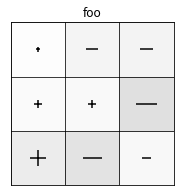

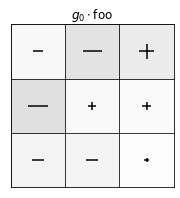

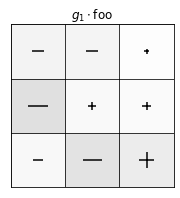

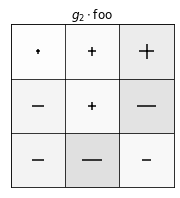

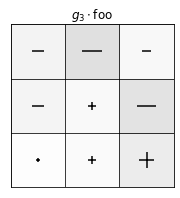

In [10]:
foo = geometric_filter(np.random.normal(size=3 ** D), 1)
plot_scalar_filter(foo, "foo")
for i, gg in enumerate(group_operators[:4]):
    plot_scalar_filter(foo.times_group_element(gg), "$g_{}\cdot$foo".format(i))

In [11]:
# Visualize the vector filters.

def plot_vectors(xs, ys, ws, boxes=True, fill=True):
    if boxes: plot_boxes(xs, ys)
    if fill: fill_boxes(xs, ys, np.sum(np.abs(ws), axis=-1))
    for x, y, w in zip(xs, ys, ws):
        if np.sum(w * w) > TINY:
            plt.arrow(x - 0.3 * w[0], y - 0.3 * w[1],
                      0.6 * w[0], 0.6 * w[1],
                      length_includes_head=True, head_width=0.1, color="k")

def plot_vector_filter(filter, title):
    assert filter.k == 1
    if filter.D not in [2, 3]:
        print("plot_vector_filter(): Only works for D in [2, 3].")
        return
    setup_plot()
    MtotheD = filter.M ** filter.D
    xs, ys, zs = np.zeros(MtotheD), np.zeros(MtotheD), np.zeros(MtotheD)
    ws = np.zeros((MtotheD, filter.D))
    for i, (kk, pp) in enumerate(zip(filter.keys(), filter.pixels())):
        ws[i] = filter[kk].data
        if filter.D == 2:
            xs[i], ys[i] = pp
        elif filter.D == 3:
            xs[i], ys[i] = pp[0] + XOFF * pp[2], pp[1] + YOFF * pp[2]
    plot_vectors(xs, ys, ws)
    finish_plot(title, filter.pixels())

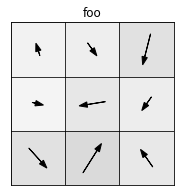

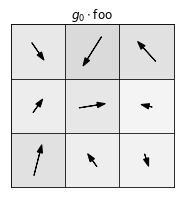

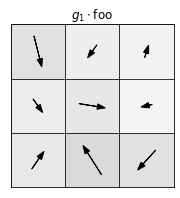

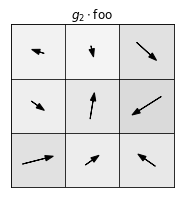

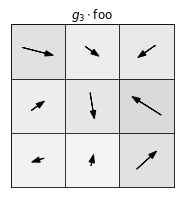

In [12]:
foo = geometric_filter(0.5 * np.random.normal(size=(3 ** D, D)), 1)
plot_vector_filter(foo, "foo")
for i, gg in enumerate(group_operators[:4]):
    plot_vector_filter(foo.times_group_element(gg), "$g_{}\cdot$foo".format(i))

# Now start the process of making the invariant filters

In [13]:
def make_zero_filter(k, parity):
    data = np.zeros((M ** D, ) + k * (D, ))
    return geometric_filter(data, parity, D)

In [14]:
# What are the unique scalar filters?
def get_unique_filters(k, parity):

    # make the seed filters
    tmp = make_zero_filter(k, parity)
    M, D, keys, shape = tmp.M, tmp.D, tmp.keys(), tmp.unpack().shape
    allfilters = []
    if k == 0:
        for kk in keys:
            thisfilter = make_zero_filter(k, parity)
            thisfilter.data[kk].data = 1
            allfilters.append(thisfilter)
    else:
        for kk in keys:
            thisfilter = make_zero_filter(k, parity)
            for indices in it.product(range(D), repeat=k):
                thisfilter.data[kk].data[indices] = 1
                allfilters.append(thisfilter)

    # do the group averaging
    bigshape = (len(allfilters), ) + thisfilter.unpack().flatten().shape
    filter_matrix = np.zeros(bigshape)
    for i, f1 in enumerate(allfilters):
        ff = make_zero_filter(k, parity)
        for gg in group_operators:
            ff = ff + f1.times_group_element(gg)
        filter_matrix[i] = ff.unpack().flatten()

    # do the SVD
    u, s, v = np.linalg.svd(filter_matrix)
    TINY = 1.e-5
    sbig = s > TINY
    if not np.any(sbig):
        return []

    # normalize the amplitudes so they max out at +/- 1.
    amps = v[sbig] / np.max(np.abs(v[sbig]), axis=1)[:, None]
    # make sure the amps are positive, generally
    for i in range(len(amps)):
        if np.sum(amps[i]) < 0:
            amps[i] *= -1
    # make sure that the zeros are zeros.
    amps[np.abs(amps) < TINY] = 0.

    # order them
    filters = [geometric_filter(aa.reshape(shape), parity) for aa in amps]
    norms = [ff.bigness() for ff in filters]
    I = np.argsort(norms)
    filters = [filters[i] for i in I]
    return filters

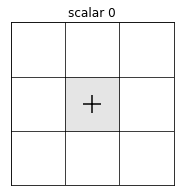

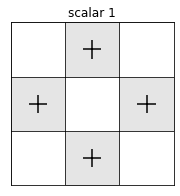

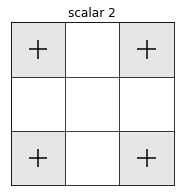

In [15]:
scalar_filters = get_unique_filters(0, 1)
for i, ff in enumerate(scalar_filters):
    plot_scalar_filter(ff, "scalar {}".format(i))

In [16]:
pseudoscalar_filters = get_unique_filters(0, -1)
for i, ff in enumerate(pseudoscalar_filters):
    plot_scalar_filter(ff, "pseudoscalar {}".format(i))

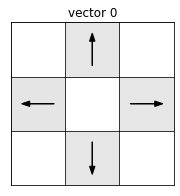

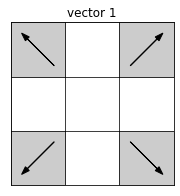

In [17]:
vector_filters = get_unique_filters(1, 1)
for i, ff in enumerate(vector_filters):
    plot_vector_filter(ff, "vector {}".format(i))

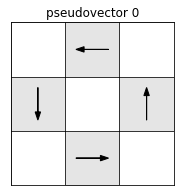

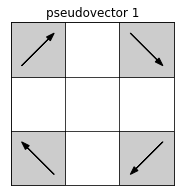

In [18]:
pseudovector_filters = get_unique_filters(1, -1)
for i, ff in enumerate(pseudovector_filters):
    plot_vector_filter(ff, "pseudovector {}".format(i))

In [19]:
tt_filters = get_unique_filters(2, 1)
for ff in tt_filters:
    print(ff)

<geometric filter object in D=2 with M=3, k=2, and parity=1>
<geometric filter object in D=2 with M=3, k=2, and parity=1>
<geometric filter object in D=2 with M=3, k=2, and parity=1>
<geometric filter object in D=2 with M=3, k=2, and parity=1>


In [20]:
# Visualize the 2-tensor filters
# HOGG TBD

In [21]:
ptt_filters = get_unique_filters(2, -1)
for ff in ptt_filters:
    print(ff)

<geometric filter object in D=2 with M=3, k=2, and parity=-1>


# Define geometric images and convolutions

In [22]:
# We need this to make fake data
!pip install finufft
import finufft

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
class geometric_image:

    def hash(self, pixel):
        """
        ## Note:
        - Deals with torus by modding (with `np.remainder()`).
        """
        return tuple(np.remainder(pixel.astype(int), self.N))

    def make_pixels_and_keys(self):
        self._pixels = np.array([pp for pp in it.product(range(self.N),
                                                         repeat=D)]).astype(int)
        self._keys = [self.hash(pp) for pp in self._pixels]
        return

    def __init__(self, data, parity, D):
        self.D = D
        self.N = len(data)
        assert data.shape[:D] == self.D * (self.N, ), \
        "geometric_filter: data must be square."
        self.make_pixels_and_keys()
        self.parity = parity
        self.data = {kk: ktensor(data[kk], self.parity, self.D)
                     for kk in self.keys()}
        self.k = self[self.keys()[0]].k
        return

    def copy(self):
        return geometric_image(self.unpack(), self.parity, self.D)

    def __getitem__(self, key):
        return self.data[key]

    def keys(self):
        return self._keys

    def pixels(self):
        return self._pixels

    def __add__(self, other):
        assert self.D == other.D
        assert self.N == other.N
        assert self.k == other.k
        assert self.parity == other.parity
        newimage = self.copy()
        for kk in self.keys():
            newimage.data[kk] = self[kk] + other[kk]
        return newimage

    def __mul__(self, other):
        assert self.D == other.D
        assert self.N == other.N
        newk, newparity = self.k * other.k, self.parity * other.parity
        newshape = self.D * (self.N, ) + newk * (self.D, )
        newimage = geometric_image(np.zeros(newshape), newparity, self.D)
        assert newimage.D == self.D
        assert newimage.N == self.N
        assert newimage.k == newk
        for kk in self.pixels():
            newimage.data[kk] = self[kk] * other[kk] # handled by ktensor
        return newimage

    def __str__(self):
        return "<geometric image object in D={} with N={}, k={}, and parity={}>".format(
            self.D, self.N, self.k, self.parity)

    def unpack(self):
        shape = self.D * (self.N, ) + self.k * (self.D, )
        package = np.zeros(shape)
        for kk in self.keys():
            package[kk] = self[kk].data
        return package

    def convolve_with(self, filter):
        newk, newparity = self.k + filter.k, self.parity * filter.parity
        shape = self.D * (self.N, ) + newk * (self.D, )
        newimage = geometric_image(np.zeros(shape), newparity, self.D)
        for kk, pp in zip(self.keys(), self.pixels()):
            for dk, dp in zip(filter.keys(), filter.pixels()):
                newimage.data[kk] += self[self.hash(pp + dp)] * filter[dk]
        return newimage


In [38]:
# make a sensible smooth scalar image on a 2-torus
N = 16
assert D == 2
np.random.seed(42)
image = np.random.normal(size=D * (N, ))
foo = np.pi * np.arange(-1. + 1. / N, 1., 2. / N)
ys, xs = np.meshgrid(foo, foo) # ys, xs or xs, ys??
ft = finufft.nufft2d1(xs.flatten(), ys.flatten(), image.flatten().astype(complex), (3, 3))
package = finufft.nufft2d2(xs.flatten(), ys.flatten(), ft).reshape(N, N).real
package /= np.sqrt(np.mean(package ** 2))
package -= np.min(package)
print(package.shape, ft.shape)
scalar_image = geometric_image(package, 1, D)
print(scalar_image)

(16, 16) (3, 3)
<geometric image object in D=2 with N=16, k=0, and parity=1>


Text(0.5, 1.0, 'scalar image')

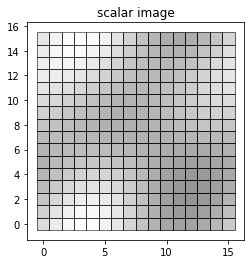

In [39]:
def plot_scalar_image(image):
    plotdata = np.array([[pp[0], pp[1], image[kk].data]
                         for kk, pp in zip(image.keys(), image.pixels())])
    plt.gca().set_aspect("equal", adjustable="box")
    plot_scalars(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2],
                 symbols=False)

plot_scalar_image(scalar_image)
plt.title("scalar image")

In [40]:
# Make a sensible smooth vector image on a 2-torus
np.random.seed(42)
imagex = np.random.normal(size=(N, N))
imagey = np.random.normal(size=(N, N))
ftx = finufft.nufft2d1(xs.flatten(), ys.flatten(), imagex.flatten().astype(complex), (3, 3))
fty = finufft.nufft2d1(xs.flatten(), ys.flatten(), imagey.flatten().astype(complex), (3, 3))
package = np.zeros((N, N, D))
package[:, :, 0] = finufft.nufft2d2(xs.flatten(), ys.flatten(), ftx).reshape(N, N).real
package[:, :, 1] = finufft.nufft2d2(xs.flatten(), ys.flatten(), fty).reshape(N, N).real
package /= np.sqrt(np.mean(package ** 2))
print(package.shape, ftx.shape)
vector_image = geometric_image(package, 1, D)
print(vector_image)

(16, 16, 2) (3, 3)
<geometric image object in D=2 with N=16, k=1, and parity=1>


In [41]:
# Now plot convlutions of images with filters
# - for example: "(scalar image) \star (pseudovector 0)"
sstarv = scalar_image.convolve_with(vector_filters[0])
print("s star v:", sstarv)
sstars = scalar_image.convolve_with(scalar_filters[0])
print("s star s:", sstars)
vstars = vector_image.convolve_with(scalar_filters[0])
print("v star s:", vstars)
vstarv = vector_image.convolve_with(vector_filters[1])
print("v star v:", vstarv)
if len(pseudovector_filters) > 0:
    vstarpv = vector_image.convolve_with(pseudovector_filters[1])
    print("v star pv:", vstarpv)

s star v: <geometric image object in D=2 with N=16, k=1, and parity=1>
s star s: <geometric image object in D=2 with N=16, k=0, and parity=1>
v star s: <geometric image object in D=2 with N=16, k=1, and parity=1>
v star v: <geometric image object in D=2 with N=16, k=2, and parity=1>
v star pv: <geometric image object in D=2 with N=16, k=2, and parity=-1>


Text(0.5, 1.0, 'scalar image STAR vector filter')

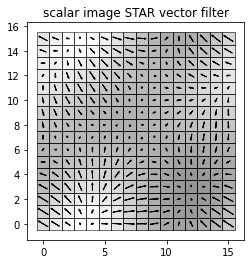

In [42]:
def plot_vector_image(image):
    plotdata = np.array([[pp[0], pp[1], image[kk].data[0], image[kk].data[1]]
                         for kk, pp in zip(image.keys(), image.pixels())])
    plt.gca().set_aspect("equal", adjustable="box")
    plot_vectors(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2:4],
                 boxes=False, fill=False)

plot_scalar_image(scalar_image)
plot_vector_image(sstarv)
plt.title("scalar image STAR vector filter")